In [4]:
import pandas as pd

import xgboost as xgb

import seaborn as sns

import optuna
import optuna_integration

from sklearn.metrics import mean_squared_error

from math import sqrt

from datetime import datetime

#### Load data

In [5]:
Y_train = pd.read_csv("../../data/ld50/train.csv")[["ld50"]]
Y_test = pd.read_csv("../../data/ld50/test.csv")[["ld50"]]

X_train = pd.read_csv("train_embeddings.csv")
X_test = pd.read_csv("test_embeddings.csv")

Y_test.describe(percentiles=[0.05, 0.5, 0.95]), Y_train.describe(percentiles=[0.05, 0.5, 0.95])

(              ld50
 count  2666.000000
 mean      2.402887
 std       0.892100
 min       0.830000
 5%        1.361634
 50%       2.198694
 95%       4.234325
 max       7.826102,
               ld50
 count  7997.000000
 mean      2.422640
 std       0.876731
 min       0.334270
 5%        1.374035
 50%       2.245123
 95%       4.208311
 max       7.427121)

In [3]:
import numpy as np
# train_mask = Y_train < np.percentile(Y_train, 95)
# filtered_y_train = Y_train[train_mask]
# filtered_x_train = X_train[train_mask]

dtrain = xgb.DMatrix(X_train, Y_train)
dtest = xgb.DMatrix(X_test, Y_test)

<Axes: >

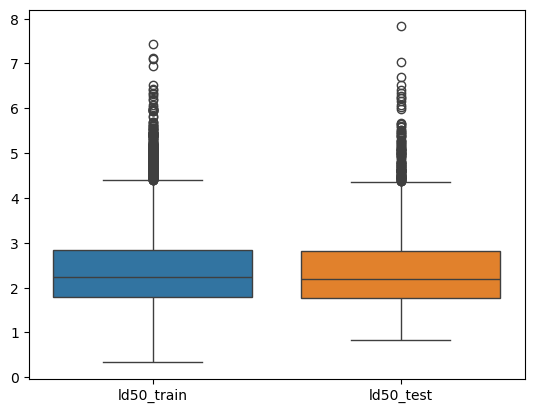

In [4]:
plot_df = Y_train.join(Y_test, lsuffix="_train", rsuffix="_test")
sns.boxplot(plot_df)

#### Train

In [7]:
best_model = None
best_eval_metric = float("inf")

def objective(trial):
    global best_model
    global best_eval_metric

    num_rounds = 5000
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 2, 6), 
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1),
        'subsample': 0.9,
        'colsample_bytree': 0.5,
    }

    progress = dict()
    evallist = [(dtest, 'test')]
    bst = xgb.train(param, dtrain, num_rounds, evals=evallist,
                    early_stopping_rounds=trial.suggest_int('early_stop', 10, 100), 
                    verbose_eval=num_rounds, 
                    evals_result=progress,
                    callbacks=[optuna_integration.XGBoostPruningCallback(trial, 'test-rmse')])

    y = bst.predict(dtest)
    eval_metric = sqrt(mean_squared_error(Y_test, y))

    if eval_metric < best_eval_metric:
        best_eval_metric = eval_metric
        best_model = bst

    return eval_metric


study = optuna.create_study(direction='minimize', 
                            storage="sqlite:///XGB_Tox_Pred.sqlite3", 
                            study_name=f"Regression{datetime.now().isoformat()}")
study.optimize(objective, n_trials=100)

[I 2024-06-17 17:13:54,363] A new study created in RDB with name: Regression2024-06-17T17:13:54.336578


[0]	test-rmse:0.88018
[911]	test-rmse:0.58214


[I 2024-06-17 17:14:31,349] Trial 0 finished with value: 0.5821387224227892 and parameters: {'max_depth': 6, 'learning_rate': 0.05673413527992878, 'early_stop': 52}. Best is trial 0 with value: 0.5821387224227892.


[0]	test-rmse:0.88132
[1851]	test-rmse:0.59167


[I 2024-06-17 17:15:25,140] Trial 1 finished with value: 0.5916826217094097 and parameters: {'max_depth': 3, 'learning_rate': 0.09099350690413194, 'early_stop': 83}. Best is trial 0 with value: 0.5821387224227892.


[0]	test-rmse:0.88352
[1607]	test-rmse:0.57811


[I 2024-06-17 17:16:24,383] Trial 2 finished with value: 0.5781119355141562 and parameters: {'max_depth': 6, 'learning_rate': 0.040576587703086885, 'early_stop': 87}. Best is trial 2 with value: 0.5781119355141562.


[0]	test-rmse:0.87272
[946]	test-rmse:0.59043


[I 2024-06-17 17:16:52,867] Trial 3 finished with value: 0.5904300285658617 and parameters: {'max_depth': 6, 'learning_rate': 0.09389702440852099, 'early_stop': 95}. Best is trial 2 with value: 0.5781119355141562.


[0]	test-rmse:0.88425
[4248]	test-rmse:0.60136


[I 2024-06-17 17:19:59,681] Trial 4 finished with value: 0.6013616156662487 and parameters: {'max_depth': 2, 'learning_rate': 0.0847557440479966, 'early_stop': 96}. Best is trial 2 with value: 0.5781119355141562.


[0]	test-rmse:0.88833


[I 2024-06-17 17:19:59,849] Trial 5 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.89030


[I 2024-06-17 17:19:59,890] Trial 6 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.87295


[I 2024-06-17 17:20:12,249] Trial 7 pruned. Trial was pruned at iteration 410.


[0]	test-rmse:0.88069
[1526]	test-rmse:0.57388


[I 2024-06-17 17:20:58,501] Trial 8 finished with value: 0.5738812221013663 and parameters: {'max_depth': 5, 'learning_rate': 0.06779734636883228, 'early_stop': 75}. Best is trial 8 with value: 0.5738812221013663.


[0]	test-rmse:0.87698


[I 2024-06-17 17:21:09,718] Trial 9 pruned. Trial was pruned at iteration 371.
[I 2024-06-17 17:21:09,775] Trial 10 pruned. Trial was pruned at iteration 0.
[I 2024-06-17 17:21:09,836] Trial 11 pruned. Trial was pruned at iteration 0.
[I 2024-06-17 17:21:09,903] Trial 12 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.89207


[I 2024-06-17 17:21:09,966] Trial 13 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.88147


[I 2024-06-17 17:21:10,023] Trial 14 pruned. Trial was pruned at iteration 0.
[I 2024-06-17 17:21:10,084] Trial 15 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.88045


[I 2024-06-17 17:21:12,635] Trial 16 pruned. Trial was pruned at iteration 115.
[I 2024-06-17 17:21:12,679] Trial 17 pruned. Trial was pruned at iteration 0.
[I 2024-06-17 17:21:12,729] Trial 18 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.87924
[705]	test-rmse:0.58306


[I 2024-06-17 17:21:29,683] Trial 19 finished with value: 0.5830395703818616 and parameters: {'max_depth': 5, 'learning_rate': 0.07669899471515296, 'early_stop': 28}. Best is trial 8 with value: 0.5738812221013663.


[0]	test-rmse:0.88462


[I 2024-06-17 17:21:29,737] Trial 20 pruned. Trial was pruned at iteration 0.
[I 2024-06-17 17:21:29,812] Trial 21 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.88189


[I 2024-06-17 17:21:29,890] Trial 22 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.87852


[I 2024-06-17 17:21:40,245] Trial 23 pruned. Trial was pruned at iteration 345.


[0]	test-rmse:0.87828


[I 2024-06-17 17:21:43,485] Trial 24 pruned. Trial was pruned at iteration 141.


[0]	test-rmse:0.88325


[I 2024-06-17 17:21:43,583] Trial 25 pruned. Trial was pruned at iteration 0.
[I 2024-06-17 17:21:43,659] Trial 26 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.88742


[I 2024-06-17 17:21:43,722] Trial 27 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.87865


[I 2024-06-17 17:21:52,618] Trial 28 pruned. Trial was pruned at iteration 292.


[0]	test-rmse:0.88782


[I 2024-06-17 17:21:52,697] Trial 29 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.87879


[I 2024-06-17 17:21:56,534] Trial 30 pruned. Trial was pruned at iteration 172.


[0]	test-rmse:0.88063


[I 2024-06-17 17:21:56,610] Trial 31 pruned. Trial was pruned at iteration 1.


[0]	test-rmse:0.87744
[742]	test-rmse:0.58255


[I 2024-06-17 17:22:15,326] Trial 32 finished with value: 0.5825451576757746 and parameters: {'max_depth': 5, 'learning_rate': 0.08792684666414922, 'early_stop': 25}. Best is trial 8 with value: 0.5738812221013663.


[0]	test-rmse:0.87554


[I 2024-06-17 17:22:19,652] Trial 33 pruned. Trial was pruned at iteration 185.


[0]	test-rmse:0.87339
[533]	test-rmse:0.58553


[I 2024-06-17 17:22:36,073] Trial 34 finished with value: 0.5855303627014662 and parameters: {'max_depth': 6, 'learning_rate': 0.09049202252632244, 'early_stop': 21}. Best is trial 8 with value: 0.5738812221013663.


[0]	test-rmse:0.87422


[I 2024-06-17 17:22:49,958] Trial 35 pruned. Trial was pruned at iteration 467.
[I 2024-06-17 17:22:50,014] Trial 36 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.87223


[I 2024-06-17 17:23:02,388] Trial 37 pruned. Trial was pruned at iteration 419.


[0]	test-rmse:0.87749


[I 2024-06-17 17:23:07,621] Trial 38 pruned. Trial was pruned at iteration 245.


[0]	test-rmse:0.88859


[I 2024-06-17 17:23:07,669] Trial 39 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.88108


[I 2024-06-17 17:23:07,757] Trial 40 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.87943


[I 2024-06-17 17:23:09,389] Trial 41 pruned. Trial was pruned at iteration 72.


[0]	test-rmse:0.87833
[670]	test-rmse:0.58135


[I 2024-06-17 17:23:25,367] Trial 42 finished with value: 0.5814048995641459 and parameters: {'max_depth': 5, 'learning_rate': 0.0823621518244942, 'early_stop': 27}. Best is trial 8 with value: 0.5738812221013663.
[I 2024-06-17 17:23:25,433] Trial 43 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.88531


[I 2024-06-17 17:23:25,491] Trial 44 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.87542


[I 2024-06-17 17:23:33,665] Trial 45 pruned. Trial was pruned at iteration 275.


[0]	test-rmse:0.87662


[I 2024-06-17 17:23:40,555] Trial 46 pruned. Trial was pruned at iteration 317.


[0]	test-rmse:0.87787


[I 2024-06-17 17:23:58,125] Trial 47 pruned. Trial was pruned at iteration 580.


[0]	test-rmse:0.88779


[I 2024-06-17 17:23:58,192] Trial 48 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.88330


[I 2024-06-17 17:23:58,249] Trial 49 pruned. Trial was pruned at iteration 0.
[I 2024-06-17 17:23:58,299] Trial 50 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.87964


[I 2024-06-17 17:23:58,682] Trial 51 pruned. Trial was pruned at iteration 15.


[0]	test-rmse:0.87802
[561]	test-rmse:0.58127


[I 2024-06-17 17:24:12,068] Trial 52 finished with value: 0.5812728073293555 and parameters: {'max_depth': 5, 'learning_rate': 0.08428587958297962, 'early_stop': 28}. Best is trial 8 with value: 0.5738812221013663.


[0]	test-rmse:0.87817


[I 2024-06-17 17:24:13,142] Trial 53 pruned. Trial was pruned at iteration 45.


[0]	test-rmse:0.87744


[I 2024-06-17 17:24:14,974] Trial 54 pruned. Trial was pruned at iteration 83.


[0]	test-rmse:0.87199


[I 2024-06-17 17:24:23,212] Trial 55 pruned. Trial was pruned at iteration 277.


[0]	test-rmse:0.87695


[I 2024-06-17 17:24:25,327] Trial 56 pruned. Trial was pruned at iteration 93.


[0]	test-rmse:0.88132


[I 2024-06-17 17:24:25,380] Trial 57 pruned. Trial was pruned at iteration 0.
[I 2024-06-17 17:24:25,446] Trial 58 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.87509


[I 2024-06-17 17:24:39,286] Trial 59 pruned. Trial was pruned at iteration 456.


[0]	test-rmse:0.88580


[I 2024-06-17 17:24:39,354] Trial 60 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.87780


[I 2024-06-17 17:24:40,878] Trial 61 pruned. Trial was pruned at iteration 66.
[I 2024-06-17 17:24:40,939] Trial 62 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.87565


[I 2024-06-17 17:24:54,642] Trial 63 pruned. Trial was pruned at iteration 456.
[I 2024-06-17 17:24:54,700] Trial 64 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.88173


[I 2024-06-17 17:24:54,763] Trial 65 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.87810


[I 2024-06-17 17:25:03,045] Trial 66 pruned. Trial was pruned at iteration 281.
[I 2024-06-17 17:25:03,110] Trial 67 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.87710
[761]	test-rmse:0.58242


[I 2024-06-17 17:25:26,832] Trial 68 finished with value: 0.5824281668319341 and parameters: {'max_depth': 6, 'learning_rate': 0.07188991339434497, 'early_stop': 75}. Best is trial 8 with value: 0.5738812221013663.
[I 2024-06-17 17:25:26,914] Trial 69 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.87705


[I 2024-06-17 17:25:37,818] Trial 70 pruned. Trial was pruned at iteration 365.


[0]	test-rmse:0.87586


[I 2024-06-17 17:25:52,006] Trial 71 pruned. Trial was pruned at iteration 474.


[0]	test-rmse:0.87353


[I 2024-06-17 17:26:00,602] Trial 72 pruned. Trial was pruned at iteration 281.


[0]	test-rmse:0.88227


[I 2024-06-17 17:26:00,671] Trial 73 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.87478


[I 2024-06-17 17:26:11,767] Trial 74 pruned. Trial was pruned at iteration 370.
[I 2024-06-17 17:26:11,819] Trial 75 pruned. Trial was pruned at iteration 0.
[I 2024-06-17 17:26:11,886] Trial 76 pruned. Trial was pruned at iteration 0.
[I 2024-06-17 17:26:11,937] Trial 77 pruned. Trial was pruned at iteration 0.
[I 2024-06-17 17:26:11,999] Trial 78 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.87941


[I 2024-06-17 17:26:12,059] Trial 79 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.87609
[944]	test-rmse:0.58245


[I 2024-06-17 17:26:42,223] Trial 80 finished with value: 0.5824396713268775 and parameters: {'max_depth': 6, 'learning_rate': 0.07692868684240325, 'early_stop': 93}. Best is trial 8 with value: 0.5738812221013663.


[0]	test-rmse:0.87523


[I 2024-06-17 17:26:50,926] Trial 81 pruned. Trial was pruned at iteration 284.


[0]	test-rmse:0.87741
[934]	test-rmse:0.58035


[I 2024-06-17 17:27:21,102] Trial 82 finished with value: 0.5803473640618285 and parameters: {'max_depth': 6, 'learning_rate': 0.07036656132971618, 'early_stop': 82}. Best is trial 8 with value: 0.5738812221013663.


[0]	test-rmse:0.87746
[934]	test-rmse:0.58039


[I 2024-06-17 17:27:51,476] Trial 83 finished with value: 0.5803929145180138 and parameters: {'max_depth': 6, 'learning_rate': 0.07011239580000872, 'early_stop': 82}. Best is trial 8 with value: 0.5738812221013663.


[0]	test-rmse:0.87733


[I 2024-06-17 17:28:20,974] Trial 84 pruned. Trial was pruned at iteration 912.


[0]	test-rmse:0.87613
[941]	test-rmse:0.57994


[I 2024-06-17 17:28:51,184] Trial 85 finished with value: 0.5799448802748343 and parameters: {'max_depth': 6, 'learning_rate': 0.0767369184298061, 'early_stop': 90}. Best is trial 8 with value: 0.5738812221013663.
[I 2024-06-17 17:28:51,326] Trial 86 pruned. Trial was pruned at iteration 0.
[I 2024-06-17 17:28:51,414] Trial 87 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.87840


[I 2024-06-17 17:28:51,506] Trial 88 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.87770


[I 2024-06-17 17:28:51,653] Trial 89 pruned. Trial was pruned at iteration 1.


[0]	test-rmse:0.87677
[931]	test-rmse:0.57981


[I 2024-06-17 17:29:21,968] Trial 90 finished with value: 0.5798140320457879 and parameters: {'max_depth': 6, 'learning_rate': 0.07353197681768595, 'early_stop': 80}. Best is trial 8 with value: 0.5738812221013663.


[0]	test-rmse:0.87661


[I 2024-06-17 17:29:44,935] Trial 91 pruned. Trial was pruned at iteration 717.


[0]	test-rmse:0.87717


[I 2024-06-17 17:29:45,177] Trial 92 pruned. Trial was pruned at iteration 4.


[0]	test-rmse:0.87568


[I 2024-06-17 17:29:52,214] Trial 93 pruned. Trial was pruned at iteration 239.


[0]	test-rmse:0.87644


[I 2024-06-17 17:30:04,850] Trial 94 pruned. Trial was pruned at iteration 419.
[I 2024-06-17 17:30:04,943] Trial 95 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.88510


[I 2024-06-17 17:30:05,047] Trial 96 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.88187


[I 2024-06-17 17:30:05,144] Trial 97 pruned. Trial was pruned at iteration 0.


[0]	test-rmse:0.87753


[I 2024-06-17 17:30:05,243] Trial 98 pruned. Trial was pruned at iteration 0.
[I 2024-06-17 17:30:05,340] Trial 99 pruned. Trial was pruned at iteration 0.


'r2_score(Y_test, outputs)=0.5861248374450201 sqrt(mean_squared_error(Y_test, outputs))=0.5738082274177668'

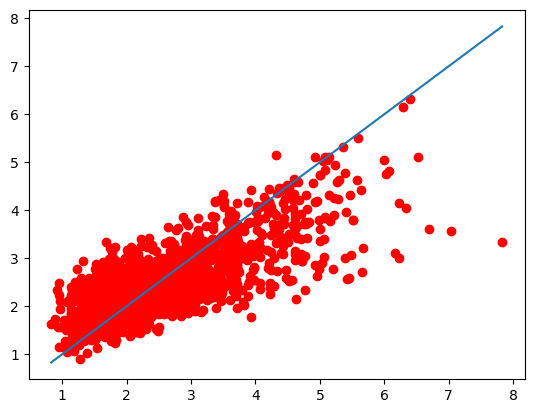

In [12]:
# bst = best_model

bst = xgb.XGBRegressor()
bst.load_model('xgboost_model_2024-06-17T18:41:09.854815.json')

outputs = bst.predict(X_test.values)

import matplotlib.pyplot as plt

max_val = max(Y_test.values.max(), outputs.max())
min_val = min(Y_test.values.min(), outputs.min())
plt.plot([[min_val], [max_val]], [[min_val], [max_val]])
plt.scatter(Y_test, outputs, color='r')

from sklearn.metrics import r2_score, mean_squared_error

f"{r2_score(Y_test, outputs)=} {sqrt(mean_squared_error(Y_test, outputs))=}"

In [10]:
from datetime import datetime
bst.save_model(f"xgboost_model_{datetime.now().isoformat()}.json")